In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
class KalmanFilterWithEmulator:
    def __init__(self, B, B_0, Q, R, Sigma_emu, mu_0, Sigma_0):
        """
        Parameters:
        - B: (n_obs x n_params) emulator linear coefficient matrix
        - B_0: (n_obs,) emulator intercept vector
        - Q: (n_params x n_params) state transition covariance (process noise)
        - R: (n_obs x n_obs) observation noise covariance
        - Sigma_emu: (n_obs x n_obs) emulator uncertainty covariance (diagonal from emulator RSEs)
        - mu_0: (n_params,) prior mean of theta
        - Sigma_0: (n_params x n_params) prior covariance of theta
        """
        self.B = B
        self.B_0 = B_0
        self.Q = Q
        self.R = R
        self.Sigma_emu = Sigma_emu
        self.Sigma_obs_total = Sigma_emu + R

        self.mu = mu_0
        self.Sigma = Sigma_0

    def step(self, y_t):
        """
        Perform one Kalman update step given observation y_t.
        Returns posterior mean and covariance of theta at this time.
        """
        # Prediction : State transition matrix F is implicitly the identity i.e. a random walk
        mu_pred = self.mu
        Sigma_pred = self.Sigma + self.Q

        # Kalman gain
        S = self.B @ Sigma_pred @ self.B.T + self.Sigma_obs_total
        K = Sigma_pred @ self.B.T @ np.linalg.inv(S)

        # Innovation (residual)
        innovation = y_t - (self.B @ mu_pred + self.B_0)

        # Update
        self.mu = mu_pred + K @ innovation
        self.Sigma = (np.eye(len(self.mu)) - K @ self.B) @ Sigma_pred

        return self.mu, self.Sigma

    def run(self, Y):
        """
        Run the filter on a sequence of observations.
        Y: (n_timesteps x n_obs) array of observations
        Returns: list of (mu_t, Sigma_t) at each time step
        """
        estimates = []
        for y_t in Y:
            mu_t, Sigma_t = self.step(y_t)
            estimates.append((mu_t.copy(), Sigma_t.copy()))
        return estimates

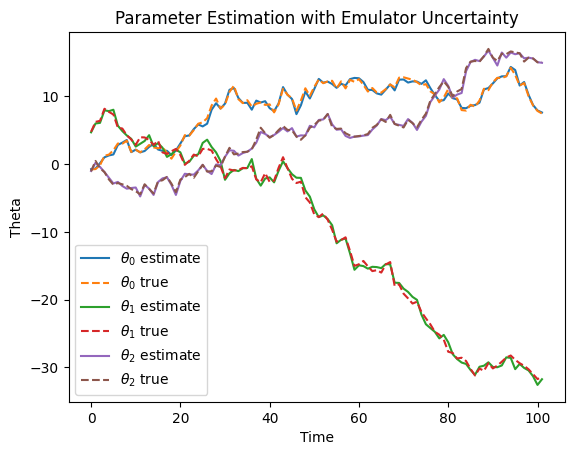

In [12]:
n_params = 3
n_obs = 5
T = 102

np.random.seed(0)

B = np.random.randn(n_obs, n_params)
B_0 = np.random.randn(n_obs) * 0.5

Q = np.eye(n_params) * 1.0
R = np.eye(n_obs) * 0.2
Sigma_emu = np.diag(np.random.uniform(0.1, 0.3, size=n_obs))

mu_0 = np.zeros(n_params)
Sigma_0 = np.eye(n_params) * 10

kf = KalmanFilterWithEmulator(B, B_0, Q, R, Sigma_emu, mu_0, Sigma_0)

# Simulate "true" theta trajectory
theta_true = np.zeros((T, n_params))
theta_true[0] = np.random.multivariate_normal(mu_0, Sigma_0)
for t in range(1, T):
    theta_true[t] = theta_true[t-1] + np.random.multivariate_normal(np.zeros(n_params), Q)

# Generate observations
Y = np.array([
    B @ theta_true[t] + B_0 + np.random.multivariate_normal(np.zeros(n_obs), Sigma_emu + R)
    for t in range(T)
])

# Run the filter
estimates = kf.run(Y)

# Plot
import matplotlib.pyplot as plt
posterior_means = np.array([mu for mu, _ in estimates])
for i in range(n_params):
    plt.plot(posterior_means[:, i], label=f"$\\theta_{i}$ estimate")
    plt.plot(theta_true[:, i], '--', label=f"$\\theta_{i}$ true")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Parameter Estimation with Emulator Uncertainty")
plt.show()

In [13]:
B.shape, B_0.shape, R.shape, Sigma_emu.shape, mu_0.shape, Sigma_0.shape, type(np.array(Y)), Y.shape

((5, 3), (5,), (5, 5), (5, 5), (3,), (3, 3), numpy.ndarray, (102, 5))

In [14]:
import pandas as pd
import os

def KFGiessenSETUP(n_samples:int=4096, 
                n_params:int=9, 
                output_path:str='output', 
                emulator_path:str=None,
                output_keys:list=None,
                include_timeseries:bool=True,
                epsilon_obs_scale:float=0.05,
                ):
        
    # Load observation data
    output_file = pd.read_csv(f"{output_path}/waveform_resampled_all_pressure_traces_rv_with_pca.csv")

    # Input for priors
    input_prior = pd.read_csv(f'{emulator_path}/input_{n_samples}_{n_params}_params.csv')

    # emulators
    emulators = pd.read_pickle(f"{emulator_path}/output_{n_samples}_{n_params}_params/emulators/linear_models_and_r2_scores_{n_samples}.pkl")

    if include_timeseries:
        all_output_keys = output_file.iloc[:, :101].columns.tolist() + output_keys
        print("Including time-series in calibraiton as specified in config file.")

        # Build the diagonal entries: 101 ones followed by the std devs
        # 101 ones are scaled by epsilon_obs_scale so they will equal 
        # 1 when multipled by epsilon_obs_scale further down. 
        sd_values = output_file[output_keys].std().values
        diagonal_values = np.concatenate([np.ones(101)/epsilon_obs_scale, sd_values]) 
    else:
        all_output_keys = output_keys
        sd_values = output_file[output_keys].std().values
        diagonal_values = sd_values

    # Create the diagonal matrix
    e_obs = np.diag(diagonal_values) * epsilon_obs_scale
    
    # Select emulators and data for specified output_keys
    emulator_output = emulators.loc[all_output_keys]
    observation_data = output_file.loc[:, all_output_keys]


    # Priors
    mu_0 = np.array(input_prior.mean().loc[:'T'])
    mu_0 = mu_0.reshape(-1, 1)
    Sigma_0 = np.diag(input_prior.var().loc[:'T'])

    # dynamically define prior on T
    mu_0[-1,-1] = observation_data['iT'].iloc[0]
    Sigma_0[-1, -1] = 0.0000001

    # Parameter names
    param_names = input_prior.loc[:, :'T'].columns.to_list()

    # Model error
    epsilon_model = np.diag(emulator_output['RSE']**2) 

# Construct beta matrix and intercepts
    beta_matrix = []
    intercept = []

    for _, row_entry in emulator_output.iterrows():
        model = row_entry['Model']
        beta_matrix.append(model.coef_)
        intercept.append(model.intercept_)
    
    beta_matrix = np.array(beta_matrix)
    intercept = np.array(intercept).reshape(len(intercept), 1)
    
    return beta_matrix, intercept, e_obs, epsilon_model, mu_0, Sigma_0, param_names, observation_data

In [15]:
#- F: Transition matrix is identitity (not included)
#- B: (n_obs x n_params) emulator linear coefficient matrix
#- B_0: (n_obs,) emulator intercept vector
#- Q: (n_params x n_params) state transition covariance (process noise)
#- R: (n_obs x n_obs) observation noise covariance
#- Sigma_emu: (n_obs x n_obs) emulator uncertainty covariance (diagonal from emulator RSEs)
#- mu_0: (n_params,) prior mean of theta
#- Sigma_0: (n_params x n_params) prior covariance of theta 

n_samples = 4096
n_params = 6
output_path = "../output_real/pat_4"
emulator_path = "../output_synthetic/"
output_keys = [  "a_epad",
      "epad",
      "s_a_epad",
      "s_epad",
      "min_dpdt",
      "max_dpdt",
      "cross_max",
      "A_p",
      "P_max",
      "esp",
      "sys",
      "EF",
      "dia",
      "Ees/Ea",
      "edp",
      "eivc",
      "iT" ]
               
include_timeseries = False
epsilon_obs_scale = 0.05

B, B_0, R, Sigma_emu, mu_0, Sigma_0, param_names, Y  = KFGiessenSETUP(n_samples=n_samples,
    n_params=n_params,
    output_path=output_path,
    emulator_path=emulator_path,
    output_keys=output_keys,
    include_timeseries=include_timeseries,
    epsilon_obs_scale=epsilon_obs_scale)


In [16]:
B.shape, B_0.flatten().shape, R.shape, Sigma_emu.shape, mu_0.flatten().shape, Sigma_0.shape, Y.shape

((17, 6), (17,), (17, 17), (17, 17), (6,), (6, 6), (2246, 17))

In [17]:
Q = np.eye(n_params) * 0.01  # Process noise covariance

kf = KalmanFilterWithEmulator(B, B_0.flatten(), Q, R, Sigma_emu, mu_0.flatten(), Sigma_0)

# Run the filter
estimates = kf.run(np.array(Y))



/var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_33103/922881350.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap(cmap, n_params)


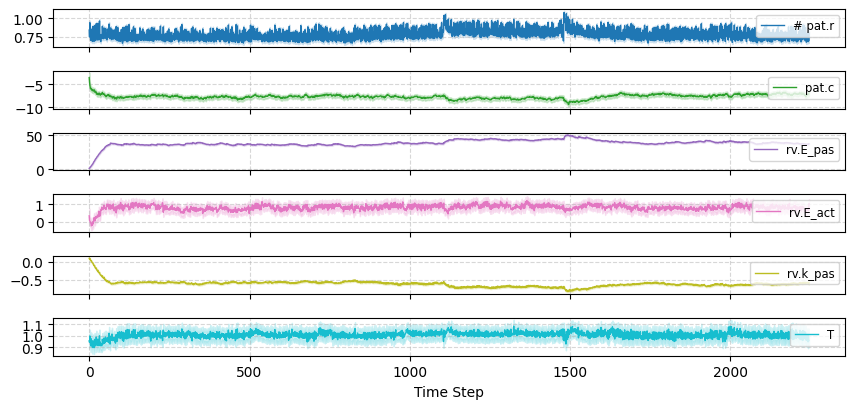

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.cm as cm

def plot_kf_estimates(estimates, param_names, confidence_level=0.95, figsize=(10, 0.7), cmap='tab10'):
    """
    Plots Kalman filter parameter estimates with confidence intervals, stacked vertically in one figure.
    
    Parameters:
    - estimates: List of (mu_t, Sigma_t) tuples from the KF run.
    - param_names: List of parameter names.
    - confidence_level: Confidence level for intervals (default=0.95).
    - figsize: Tuple specifying width and height per subplot row.
    - cmap: Matplotlib colormap name for assigning colours.
    """
    n_timesteps = len(estimates)
    n_params = len(param_names)

    z = stats.norm.ppf(0.5 + confidence_level / 2)

    mu_series = np.array([mu for mu, _ in estimates])  # shape: (n_timesteps, n_params)
    sigma_series = np.array([np.sqrt(np.diag(Sigma)) for _, Sigma in estimates])  # shape: (n_timesteps, n_params)

    time = np.arange(n_timesteps)

    fig, axes = plt.subplots(n_params, 1, figsize=(figsize[0], figsize[1]*n_params), sharex=True)

    if n_params == 1:
        axes = [axes]  # ensure axes is iterable

    # Generate distinct colours using a colormap
    color_map = cm.get_cmap(cmap, n_params)
    colors = [color_map(i) for i in range(n_params)]

    for i, ax in enumerate(axes):
        color = colors[i]
        ax.plot(time, mu_series[:, i], color=color, label=param_names[i], linewidth=1)
        ax.fill_between(time, 
                        mu_series[:, i] - z * sigma_series[:, i],
                        mu_series[:, i] + z * sigma_series[:, i],
                        color=color, alpha=0.2)
        
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(loc='upper right', fontsize='small')
        #if i == 0:
        #    ax.legend(loc='upper right', fontsize='small')
    
    axes[-1].set_xlabel("Time Step")

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()

plot_kf_estimates(estimates, param_names)